# Final Notebook

In [1]:
# Path to load files
file_path = "datasets/final_UNSW-NB15/"

## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score

%matplotlib inline

## Loading Data

In [3]:
# Raw data and labels
x_test, y_test = pickle.load(open(file_path+'final_test.pkl', 'rb'))

# Dictionary with useful parameters
saved_dict = pickle.load(open(file_path+'saved_dict.pkl', 'rb'))
# Dictionary with mode of all the columns of train data, useful for fill any values in test
mode_dict = pickle.load(open(file_path+'mode_dict.pkl', 'rb'))

# Standardscaler
scaler = pickle.load(open(file_path+'scaler.pkl', 'rb'))

# Ohehotencoders
ohe_proto = pickle.load(open(file_path+'ohe_proto.pkl', 'rb'))
ohe_service = pickle.load(open(file_path+'ohe_service.pkl', 'rb'))
ohe_state = pickle.load(open(file_path+'ohe_state.pkl', 'rb'))

# Best model found on train data, here it is Randomforest Classifier trained on only important features
best_model = pickle.load(open(file_path+'rf_clf_imp.pkl', 'rb'))

## Utility Functions

In [4]:
#------------------------------------------------------------------------------------------
# Data Cleaning
#------------------------------------------------------------------------------------------
def clean_data(data):
    '''
    Cleans given raw data. Performs various cleaning, removes Null and wrong values.
    Check for columns datatype and fix them.
    '''
    numerical_col = data.select_dtypes(include=np.number).columns  # All the numerical columns list
    categorical_col = data.select_dtypes(exclude=np.number).columns  # All the categorical columns list
    
    # Cleaning the data
    for col in data.columns:
        val = mode_dict[col]  # Mode value of the column in train data
        data[col] = data[col].fillna(value=val)
        data[col] = data[col].replace(' ', value=val)
        data[col] = data[col].apply(lambda x:"none" if x=="-" else x)
        # Fixing binary columns
        if col in saved_dict['binary_col']:
            data[col] = np.where(data[col]>1, val, data[col])

    # Fixing datatype of columns
    bad_dtypes = list(set(categorical_col) - set(saved_dict['cat_col']))
    for bad_col in bad_dtypes:
        data[col] = data[col].astype(float)
    
    return data

#------------------------------------------------------------------------------------------
# Feature Engineering: Apply log1p
#------------------------------------------------------------------------------------------
def apply_log1p(data):
    '''
    Performs FE on the data. Apply log1p on the specified columns create new column and remove those original columns.
    '''
    for col in saved_dict['log1p_col']:
        new_col = col + '_log1p'  # New col name
        data[new_col] = data[col].apply(np.log1p)  # Creating new column on transformed data
        data.drop(col, axis=1, inplace=True)  # Removing old columns
    return data

#------------------------------------------------------------------------------------------
# Standardizing: Mean centering an d varience scaling
#------------------------------------------------------------------------------------------
def standardize(data):
    '''
    Stanardize the given data. Performs mean centering and varience scaling.
    Using stanardscaler object trained on train data.
    '''
    data[saved_dict['num_col']] = scaler.transform(data[saved_dict['num_col']])
    return data

#------------------------------------------------------------------------------------------
# Onehot encoding of categorical columns
#------------------------------------------------------------------------------------------
def ohencoding(data):
    '''
    Onehot encoding the categoricla columns.
    Add the ohe columns with the data and removes categorical columns.
    Using Onehotencoder objects trained on train data.
    '''
    # Onehot encoding cat col using onehotencoder objects
    X = ohe_service.transform(data['service'].values.reshape(-1, 1))
    Xm = ohe_proto.transform(data['proto'].values.reshape(-1, 1))
    Xmm = ohe_state.transform(data['state'].values.reshape(-1, 1))
    
    # Adding encoding data to original data
    data = pd.concat([data,
                      pd.DataFrame(Xm.toarray(), columns=['proto_'+i for i in ohe_proto.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in ohe_service.categories_[0]]),
                      pd.DataFrame(Xmm.toarray(), columns=['state_'+i for i in ohe_state.categories_[0]])],
                      axis=1)
    
    # Removing cat columns
    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)
    return data

In [5]:
def final_fun_1(X):
    """
    This function includes entire pipeline, from data preprocessing to making final predictions.
    It takes take in raw data as input.
    It returns predictions for given input. Here the input can be a single point or a set of points.
    """
    # Using dataframe for data preprocessing, So if single point given as input
    # Then converting that to DataFrame with 1 row
    if isinstance(X, pd.core.series.Series):
        # For single input as series
        data = pd.DataFrame(X.values.reshape(1, -1)).copy()
    else:
        data = X.copy()
    
    # Resetting index of the given df and adding correct columns names mentioned in research paper
    data.reset_index(drop=True, inplace=True)
    data.columns = saved_dict['columns']

    # FE: Adding 1 new feature
    data['network_bytes'] = data['dbytes'] + data['sbytes']

    # Dropping columns not needed for prediction
    dropable_col = saved_dict['to_drop'] + saved_dict['corr_col']
    data.drop(columns=dropable_col, inplace=True)

    # Cleaning and preprocessig
    data = clean_data(data)
    data = apply_log1p(data)
    data = standardize(data)
    data = ohencoding(data)

    # Using only Important features
    data = data.iloc[:, saved_dict['imp_indices']]
    
    # Predicting using best model
    predictions = best_model.predict(data)
    
    # Returning predictions on the given data
    return predictions

In [6]:
x_test.shape

(762015, 48)

In [7]:
# For single datapoint
y_pred = final_fun_1(x_test.iloc[0])

In [8]:
y_pred, y_test.iloc[0]

(array([0]), np.int64(0))

In [9]:
# For few datapoints
y_pred = final_fun_1(x_test.iloc[90:100])

In [10]:
print(y_pred)
print(y_test.iloc[90:100].values)

[0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 1 0 0]


In [11]:
# For entire test data
y_pred = final_fun_1(x_test)

In [12]:
# f1 score of total test data
f1_score(y_test.values, y_pred)

# same as found during training

np.float64(0.9781740028586631)

In [13]:
x_test.shape

(762015, 48)

In [14]:
def final_fun_2(X, Y):
    """
    This function includes entire pipeline, from data preprocessing to making final predictions.
    It takes in raw data as input along with its target values.
    It returns the metric value that has been selected for judging model's performance
    Also retuns auc curve, confusion, precision and recall matrix
    """
    # Getting target value and predicted value for the given data
    y_true = Y.copy()
    y_pred = final_fun_1(X) # By using final_fun_1 getting predicted values

    # auc curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    
    # Confusion, precison and recall matrix
    C = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = C.ravel()
    FPR = fp / (fp + tn)
    FNR = fn / (fn + tp)

    P = (C/C.sum(axis=0))
    R =(((C.T)/(C.sum(axis=1))).T)

    # Scores of test dataset
    y_auc = auc(fpr, tpr)
    y_f1 = f1_score(y_true, y_pred)
    y_far = (FPR+FNR)/2  # False alarm rate

    # Printing the result as a table
    x = PrettyTable()
    x.field_names = ['AUC', 'F1-score', 'False Alarm Rate']
    x.add_row([y_auc, y_f1, y_far])
    print(x)

    # Plotting AUC curve
    plt.figure(figsize=(12, 5))
    plt.plot(fpr, tpr, color='r', label=f"AUC: {y_auc}")
    plt.grid()
    plt.legend()
    plt.show()

    # Plotting Confusion, Precision, Recall Matrix
    labels= ['non-attack', 'attack']
    # Confusion
    plt.figure(figsize=(18,5))
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap="Blues", fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    # Precision
    plt.subplot(1,3,2)
    sns.heatmap(P, annot=True, cmap="Greens", fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Precision Matrix")
    # Recall
    plt.subplot(1,3,3)
    sns.heatmap(R, annot=True, cmap="BuPu", fmt='.3f', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Recall Matrix")
    plt.show()
    
    # Retuning performance metrices
    return y_auc, y_f1, y_far

+--------------------+--------------------+----------------------+
|        AUC         |      F1-score      |   False Alarm Rate   |
+--------------------+--------------------+----------------------+
| 0.9863710191357385 | 0.9781740028586631 | 0.013628980864261488 |
+--------------------+--------------------+----------------------+


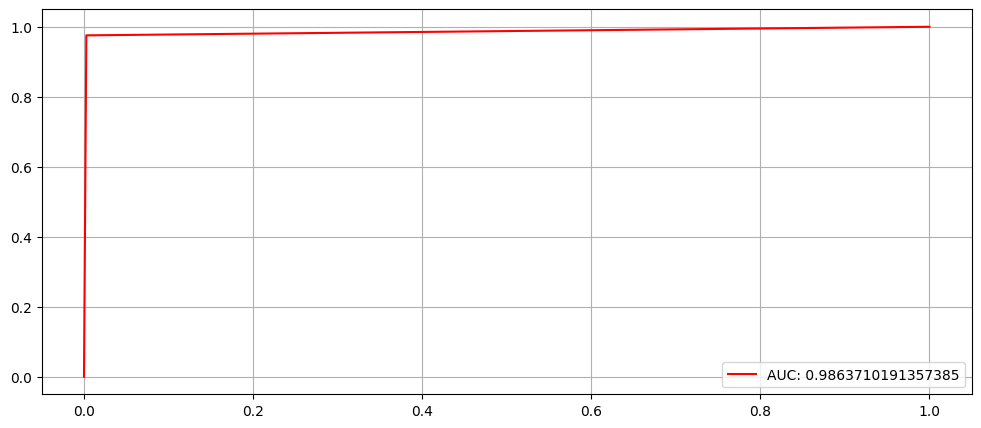

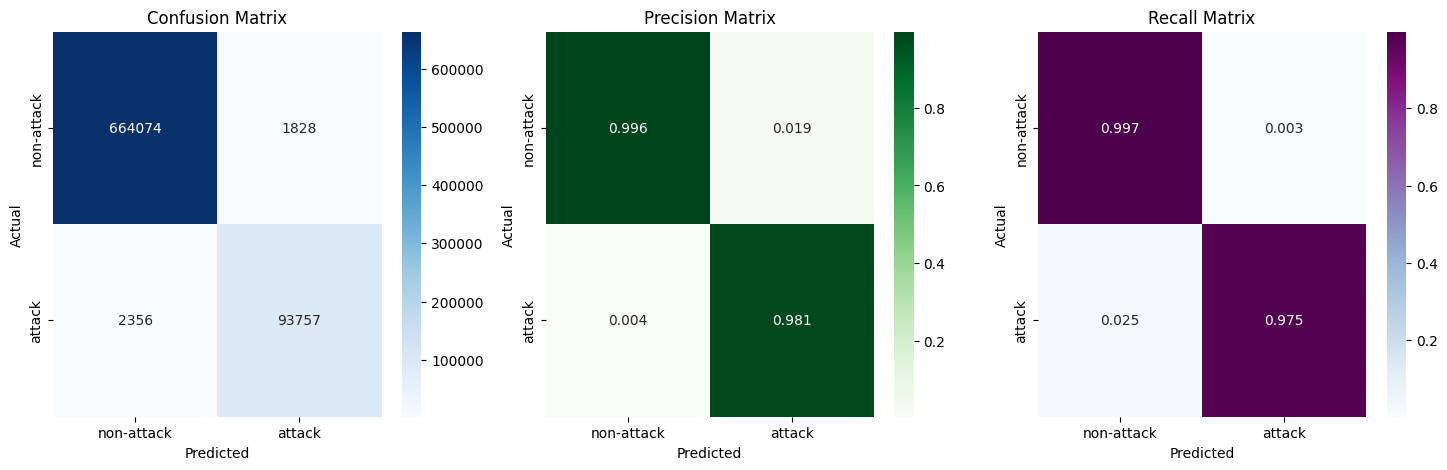

In [15]:
# Using entire data
auc, f1, far = final_fun_2(x_test, y_test.values)

In [16]:
print(auc, f1, far)

0.9863710191357385 0.9781740028586631 0.013628980864261488


In [17]:
x_test.shape, y_test.shape

((762015, 48), (762015,))